In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-HMM-BinomialLatticeModel`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-HMM-BinomialLatticeModel/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-HMM-BinomialLatticeModel/Manifest.toml`


In [2]:
# load required packages -
using Distributions
using Plots
using Colors

# setup paths -
const _ROOT = pwd();
const _PATH_TO_FIGS = joinpath(_ROOT, "figs");

In [3]:
# setup some constants -
T = 45;       # number of time steps
ΔT = (1/365); # time-step
IV = 24.20;   # Implied volatility
σ = (IV/100); # approx vol
Sₒ = 100.0;   # initial price

#### a) Compute the MC stationary distribution

In [11]:
# setup my transition array -

# optimistic
P = [
    0.7 0.3 ; # state 1 up
    0.6 0.4 ; # state 2 down
];

# pessimistic 
# P = [
#     0.3 0.7 ; # state 1 up
#     0.6 0.4 ; # state 2 down
# ];

# stationary d -
π_probability = (P^100)[1,:]

2-element Vector{Float64}:
 0.6666666666666629
 0.33333333333333154

#### b) Build a Categorical distribution using the MC stationary distribution

In [5]:
# build a categorical distribution -
d = Categorical(π_probability);

# setup the up and down move dict -
move_dictionary = Dict{Int64,Float64}();
move_dictionary[1] = exp(σ*sqrt(ΔT));
move_dictionary[2] = exp(-σ*sqrt(ΔT));

In [6]:
# sample -
number_of_time_steps = T;
number_of_paths = 250;

# build an array of possible trajectories -
Z = rand(d, T, number_of_paths);

# price array -
PA = Array{Float64,2}(undef, number_of_time_steps+1, number_of_paths);
fill!(PA,0.0);

# add initial condition -
for p ∈ 1:number_of_paths
    PA[1,p] = Sₒ;
end

# main loop -
for t ∈ 1:number_of_time_steps
    for p ∈ 1:number_of_paths
        
        # grab a state -
        state_index = Z[t,p];
        f = move_dictionary[state_index];
        PA[t+1,p] = PA[t,p]*f;
    end
end

In [7]:
PA

46×250 Matrix{Float64}:
 100.0     100.0     100.0     100.0     …  100.0     100.0     100.0
 101.275    98.7413   98.7413   98.7413      98.7413  101.275    98.7413
 102.566    97.4984  100.0      97.4984      97.4984  102.566    97.4984
 101.275    96.2712  101.275    96.2712      98.7413  101.275    96.2712
 100.0      95.0595  100.0      97.4984      97.4984  100.0      97.4984
  98.7413   96.2712   98.7413   96.2712  …   96.2712  101.275    98.7413
 100.0      97.4984   97.4984   97.4984      97.4984  100.0     100.0
 101.275    96.2712   98.7413   96.2712      96.2712   98.7413  101.275
 100.0      95.0595   97.4984   97.4984      95.0595   97.4984  100.0
  98.7413   93.863    96.2712   96.2712      93.863    98.7413   98.7413
 100.0      95.0595   95.0595   97.4984  …   95.0595   97.4984   97.4984
  98.7413   93.863    96.2712   98.7413      93.863    98.7413   96.2712
 100.0      92.6815   95.0595   97.4984      95.0595   97.4984   97.4984
   ⋮                                 

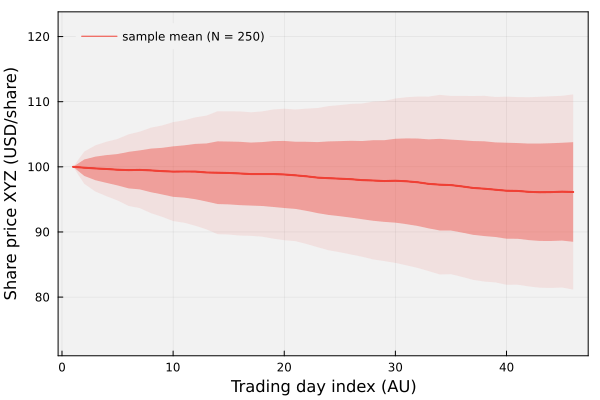

In [10]:
# Let's compute some states from the samples -
μ = mean(PA,dims=2);
L = μ .- std(PA, dims=2);
U = μ .+ std(PA, dims=2);
L2 = μ .- 1.96*std(PA, dims=2);
U2 = μ .+ 1.96*std(PA, dims=2);

min_value = 0.95*minimum(PA[end,:]);
max_value = 1.05*maximum(PA[end,:]);

plot(μ, fillrange=U, fillalpha = 0.4, label="", c=colorant"#EF4035", legend=:topleft, bg=colorant"#F2F2F2", 
    background_color_outside="white", framestyle = :box, fg_legend = :transparent, ylim=(min_value, max_value))
plot!(μ, fillrange=L, fillalpha = 0.4, label="", c=colorant"#EF4035")
plot!(μ, fillrange=L2, fillalpha = 0.1, label="", c=colorant"#EF4035")
plot!(μ, fillrange=U2, fillalpha = 0.1, label="", c=colorant"#EF4035")
plot!(μ, label="sample mean (N = $(number_of_paths))", lw=2, c=colorant"#EF4035")

# setup the labels -
xlabel!("Trading day index (AU)", fontsize=18)
ylabel!("Share price XYZ (USD/share)", fontsize=18)

# uncomment me to save figure -
# filename="Fig-HMM-down-SRA-N250.pdf"
# savefig(joinpath(_PATH_TO_FIGS, filename));